# LeNet
    它是最早发布的卷积神经网络之一，因其在计算机视觉任务中的高效性能而受到广泛关注。这个模型是由AT&T贝尔实验室的研究员Yann LeCun在1989年提出的（并以其命名），目的是识别图像 [LeCun et al., 1998]中的手写数字。当时，Yann LeCun发表了第一篇通过反向传播成功训练卷积神经网络的研究，这项工作代表了十多年来神经网络研究开发的成果。
当时，LeNet取得了与支持向量机（support vector machines）性能相媲美的成果，成为监督学习的主流方法。

总体来看，LeNet（LeNet-5）由俩个部分组成：
* 卷积编码器（卷积层）：由两个卷积层组成。
* 全连接层：由三个全连接层组成。

<img src="pic\18.jpg" width="600"/>

每个卷积块中的基本单元是<font color=LightCoral>一个卷积层</font>、<font color=LightCoral>一个sigmoid激活函数</font>和<font color=LightCoral>平均汇聚层</font>。请注意，虽然ReLU和最大汇聚层更有效，但它们在20世纪90年代还没有出现。每个卷积层使用**5x5**卷积核和一个sigmoid激活函数。这些层将输入映射到多个二维特征输出，通常同时增加通道的数量。第一卷积层有6个输出通道，而第二个卷积层有16个输出通道。每个**2x2**池操作（步骤2）通过空间下采样将维数减少4倍。卷积的输出形状由批量大小、通道数、高度、宽度决定。

为了将卷积块的输出传递给稠密块，我们必须在小批量中展平每个样本。换言之，我们将这个四维输入转换成全连接层所期望的二维输入。**这里的二维表示的第一个维度索引小批量中的样本，第二个维度给出每个样本的平面向量表示**。LeNet的稠密块有三个全连接层，分别有120、84和10个输出。因为我们在执行分类任务，所以输出层的10维对应于最后输出结果的数量。

In [23]:
import torch
from torchvision import transforms
from  torch.utils import data 
import torchvision
import matplotlib.pyplot as plt

## 获取数据集
    使用Fashion-MNIST图像分类数据集

In [24]:
'''下载数据集'''
def load_data(batch_size):
    # 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
    # 并除以255使得所有像素的数值均在0到1之间
    trans = transforms.ToTensor()
    #下载训练数据
    mnist_train = torchvision.datasets.FashionMNIST(
        root="datasets",  #保存的目录
        train=True,       #下载的是训练数据集
        transform=trans,   #得到的是pytorch的tensor，而不是图片
        download=True)  #从网上下载
    #下载测试数据
    mnist_test = torchvision.datasets.FashionMNIST(
        root="datasets", train=False, transform=trans, download=True)
    len(mnist_train),len(mnist_test)
    #装载数据
    data_loader_train=data.DataLoader(dataset=mnist_train,
                                                batch_size=batch_size,
                                                shuffle=True)   #数据是否打乱
    data_loader_test=data.DataLoader(dataset=mnist_test,
                                    batch_size=batch_size,
                                    shuffle=True)
    return data_loader_train,data_loader_test

## 模型定义

In [25]:
net=torch.nn.Sequential(
    #第一层卷积
    torch.nn.Conv2d(in_channels=1,  #输入通道
                    out_channels=6,  #输出通道
                    kernel_size=5,padding=2),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2,stride=2),
    #第二层卷积
    torch.nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
    torch.nn.Sigmoid(),
    torch.nn.AvgPool2d(kernel_size=2,stride=2),
    #全连接层
    torch.nn.Flatten(), 
    torch.nn.Linear(16*5*5,120),
    torch.nn.Sigmoid(),
    torch.nn.Linear(120,84),
    torch.nn.Sigmoid(),
    torch.nn.Linear(84,10)  #最后输出十个
)

我们对原始模型做了一点小改动，去掉了最后一层的**高斯激活**。除此之外，这个网络与最初的LeNet-5一致。

In [26]:
#x=torch.rand(size=(1,1,28,28),dtype=torch.float32)
#for layer in net:
#    x=layer(x)
#    print(layer.__class__.__name__,'output shape: \t',x.shape)

## 模型训练

In [34]:
'''定义预测准确率函数'''
def acc(y_hat,y):
    '''
    :param y_hat: 接收二维张量，例如 torch.tensor([[1], [0]...])
    :param y: 接收二维张量，例如 torch.tensor([[0.1, 0.2, 0.7], [0.8, 0.1, 0.1]...]) 三分类问题
    :return:
    '''
    y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y  #数据类型是否相同
    return float(cmp.type(y.dtype).sum())
    
class Accumulator():
    ''' 对评估的正确数量和总数进行累加 '''
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, item):
        return self.data[item]

'''自定义每个批次训练函数'''
def train_epoch(net,train_iter,loss,optimizer):
    #判断是不是pytorch得model，如果是，就打开训练模式，pytorch得训练模式默认开启梯度更新
    if isinstance(net,torch.nn.Module):
        net.train()
    #创建样本累加器【累加每批次的损失值、样本预测正确的个数、样本总数】
    metric = Accumulator(3)  
    for x,y in train_iter:
        #前向传播获取预测结果
        y_hat=net(x)
        #计算损失
        l=loss(y_hat,y) 
        #判断是pytorch自带得方法还是我们手写得方法（根据不同得方法有不同得处理方式）
        if isinstance(optimizer,torch.optim.Optimizer):
            #梯度清零
            optimizer.zero_grad()
            #损失之求和，反向传播（pytorch自动进行了损失值计算）
            l.backward()
            #更新梯度
            optimizer.step()
            #累加个参数
            metric.add(
                float(l)*len(y),  #损失值总数
                acc(y_hat,y),     #计算预测正确得总数
                y.size().numel()  #样本总数
            )
    #返回平均损失值，预测正确得概率
    return metric[0]/metric[2],metric[1]/metric[2]

'''模型测试'''
def test_epoch(net,test_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()  #将模型设置为评估模式
    metric=Accumulator(2)
    for x,y in test_iter:
        metric.add(
            acc(net.forward(x),y),  #计算准确个数
            y.numel()  #测试样本总数
        )
    return metric[0]/metric[1]

'''正式训练'''
def train_LeNet(num_epochs,net,trian_iter,test_iter,lr):
    loss_list=[]
    train_acc=[]
    test_acc=[]
    #初始化权重
    def init_weight(m):
        if type(m)==torch.nn.Linear or type(m)==torch.nn.Conv2d:
            torch.nn.init.xavier_normal_(m.weight)
    net.apply(init_weight)
    #损失函数
    loss=torch.nn.CrossEntropyLoss()
    #优化器
    optimizer=torch.optim.SGD(net.parameters(),lr=lr)
    #训练
    for epoch in range(num_epochs):
        #返回平均损失值和正确率
        train_metrics=train_epoch(net,trian_iter,loss,optimizer)
        loss_list.append(train_metrics[0])  #保存loss
        train_acc.append(train_metrics[1])   #保存准确率
        #测试集
        test_metric=test_epoch(net,test_iter)
        test_acc.append(test_metric)
        print(f"epoch{epoch+1}:loss={train_metrics[0]},train_acc={train_metrics[1]*100:.2f}%,test_acc={test_metric:.2f}%")
    
    return loss_list,train_acc,test_acc

'''可视化'''
def draw(num_epochs,loss_list,train_acc,test_acc):
    fig,ax=plt.subplots()   #定义画布
    ax.grid(True)          #添加网格
    ax.set_xlabel("epoch")
    #ax.set_ylim(0,1)

    ax.plot(range(num_epochs),loss_list,label="loss")
    ax.plot(range(num_epochs),train_acc,dashes=[6, 2],label="train")
    ax.plot(range(num_epochs),test_acc,dashes=[6, 2],label="test")
    ax.legend()
    plt.show()

In [32]:
batch_size=64
num_epochs=10
lr=0.1
#数据集
train_iter,test_iter=load_data(batch_size=64)
#训练
loss_list,train_acc,test_acc=train_LeNet(num_epochs,net,train_iter,test_iter,lr)


epoch1:loss=2.3118427975972495,train_acc=9.84%,test_acc=0.10%
epoch2:loss=2.2952617866516114,train_acc=12.10%,test_acc=0.26%
epoch3:loss=1.3453113689104716,train_acc=51.86%,test_acc=0.62%
epoch4:loss=0.9015567717552185,train_acc=66.22%,test_acc=0.68%
epoch5:loss=0.7867588753700256,train_acc=70.78%,test_acc=0.71%
epoch6:loss=0.7023654979070028,train_acc=73.15%,test_acc=0.74%
epoch7:loss=0.6545644786198934,train_acc=74.77%,test_acc=0.74%
epoch8:loss=0.6255917966206869,train_acc=75.78%,test_acc=0.76%
epoch9:loss=0.6011035917599996,train_acc=76.90%,test_acc=0.77%
epoch10:loss=0.5790888951301575,train_acc=77.72%,test_acc=0.75%


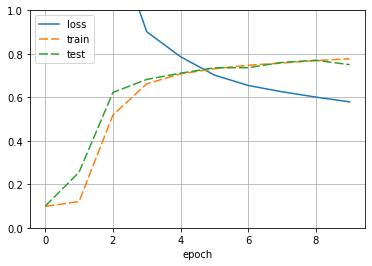

In [35]:
#可视化
draw(num_epochs,loss_list,train_acc,test_acc)